This notebook simulates thermodynamic cooling for 1D TFIM using Pauli Propagagation and studies the effects of truncation by plotting various quantities against inverse temperature Beta 

In [34]:
# reference: https://github.com/MSRudolph/PauliPropagation.jl/blob/main/examples/imaginary-time-evolution.ipynb
using PauliPropagation

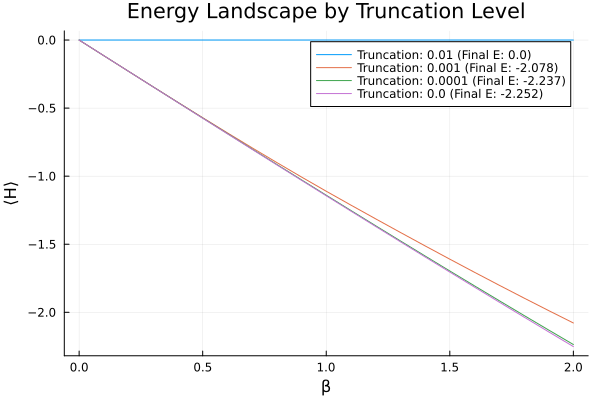

In [35]:
using Plots
h=0.5
J = 1.0
τ = 0.1
nq = 10
beta = 2.0
nlayers = round(Int, beta / τ)
rho_maxmixed = PauliString(nq, :I, 1)
topology = bricklayertopology(nq)

H = PauliSum(nq)
for i in 1:nq
    add!(H, :X, i, h)
end
for pair in topology
    add!(H, [:Z, :Z], pair, J)
end


truncation_levels = [1e-2, 1e-3, 1e-4, 0.0]

plt = plot(
    xlabel="β", 
    ylabel="⟨H⟩", 
    title="Energy Landscape by Truncation Level",
    legend=:topright
)


for min_abs_coeff in truncation_levels
    
    rho_beta = deepcopy(rho_maxmixed)
    
    energies = Float64[scalarproduct(H, rho_beta)]
    
    for layer in 1:nlayers
        rho_beta = propagate!(
            imaginary_circuit, 
            rho_beta, 
            imaginary_params; 
            heisenberg=false, 
            min_abs_coeff=min_abs_coeff # Pass the current truncation level
        )
        push!(energies, scalarproduct(H, rho_beta))
    end
    
    betas = LinRange(0, beta, length(energies))
    

    plot!(
        plt, 
        betas, 
        energies, 
        label="Truncation: $min_abs_coeff (Final E: $(round(energies[end], digits=3)))"
    )
end

display(plt)

In [36]:


τ = 0.01
imaginary_circuit = Gate[]
imaginary_params = Float64[]
topology = [(i, i+1) for i in 1:nq-1]

for i in 1:nq
    push!(imaginary_circuit, ImaginaryPauliRotation([:X], [i]))
    push!(imaginary_params, -τ * h)
end
for pair in topology
    push!(imaginary_circuit, ImaginaryPauliRotation([:Z, :Z], pair))
    push!(imaginary_params, -τ * J)
end

In [37]:

beta_max = 6.0
nlayers = round(Int, beta_max / τ)
betas = LinRange(0, beta_max, nlayers + 1)


601-element LinRange{Float64, Int64}:
 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, …, 5.95, 5.96, 5.97, 5.98, 5.99, 6.0

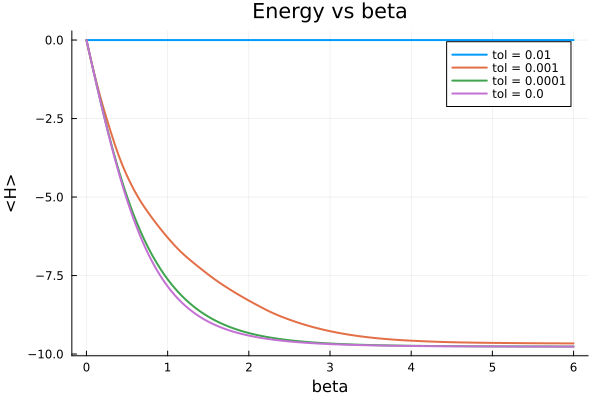

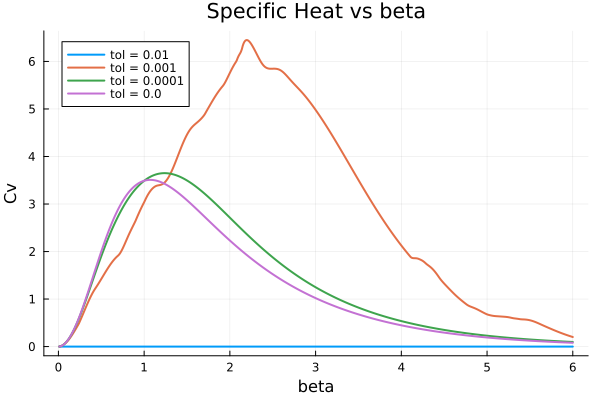

In [38]:

truncation_levels = [1e-2, 1e-3, 1e-4, 0.0]
Energy_results = Dict()
SpecHeat_results = Dict()

# Run the evolution, measure <H> at each beta, then derive Cv via finite differences
for tol in truncation_levels
    rho_beta = PauliString(nq, :I, 1)  # Start at infinite temperature (beta=0)
    
    # Measure initial energy <H> at beta=0
    energies = Float64[scalarproduct(H, rho_beta)] # H is the generator PauliSum, so this gives the expectation value of H in the current state
    
    for layer in 1:nlayers
        # Evolve state by one Trotter step
        rho_beta = propagate(imaginary_circuit, rho_beta, imaginary_params; heisenberg=false, min_abs_coeff=tol)
        
        # Measure <H> at current beta
        push!(energies, scalarproduct(H, rho_beta))
    end
    
    Energy_results[tol] = energies
    
    # Specific heat via thermodynamic relation: Cv = -beta^2 * d<H>/dbeta
    # Use finite differences; result has nlayers points (one fewer than energies)
    dbeta = step(betas)
    dE_dbeta = diff(energies) ./ dbeta
    Cv = -betas[2:end].^2 .* dE_dbeta
    
    SpecHeat_results[tol] = Cv
end

# Plot energies
p1 = plot(xlabel="beta", ylabel="<H>",
          title="Energy vs beta", legend=:topright)
for tol in truncation_levels
    plot!(p1, betas, Energy_results[tol], label="tol = $tol", linewidth=2)
end
display(p1)

# Plot specific heat
p2 = plot(xlabel="beta", ylabel="Cv",
          title="Specific Heat vs beta", legend=:topleft)
for tol in truncation_levels
    plot!(p2, betas[2:end], SpecHeat_results[tol], label="tol = $tol", linewidth=2)
end
display(p2)


Running tol = 0.01
Running tol = 0.001
Running tol = 0.0001
Running tol = 0.0
Done!


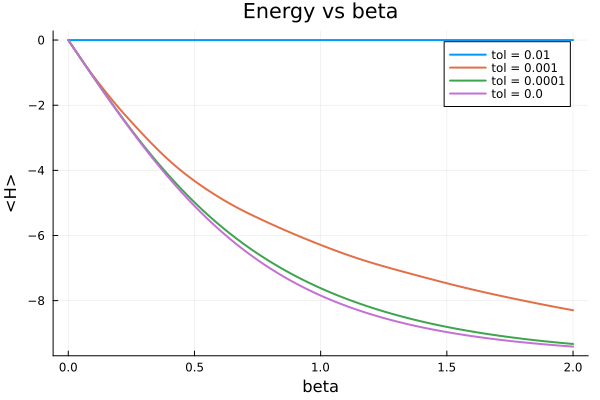

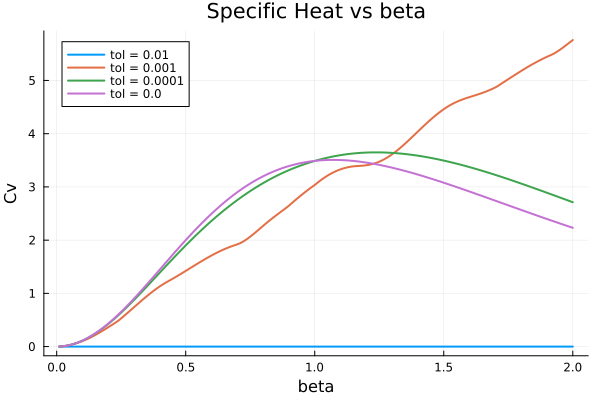

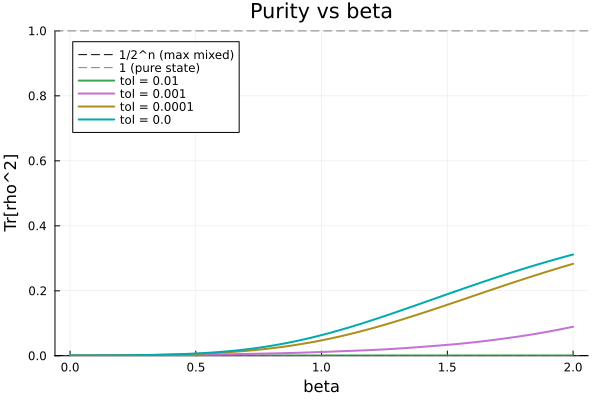

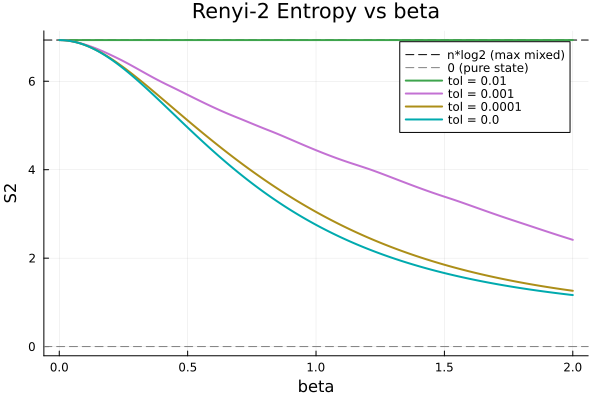

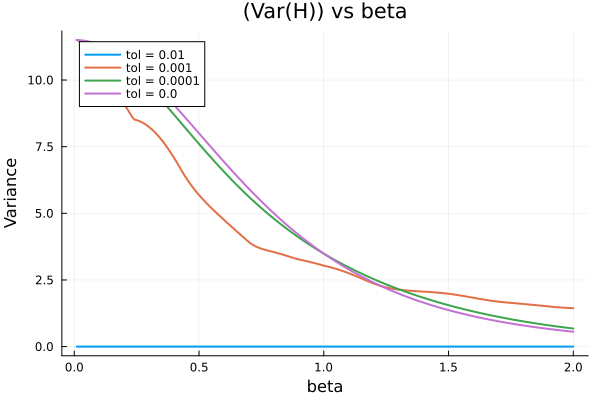

In [39]:
truncation_levels = [1e-2, 1e-3, 1e-4, 0.0]
Energy_results   = Dict()
SpecHeat_results = Dict()
Purity_results   = Dict()
Renyi2_results   = Dict()
Var_results      = Dict()

beta_max = 2.0
nlayers = round(Int, beta_max / τ)
betas = LinRange(0, beta_max, nlayers + 1)

# For the normalized density matrix rho/Tr[rho], purity = Tr[(rho/Tr[rho])^2]:
#   purity = sum_i a_i^2 / 2^n
# overlapwithpaulisum(rho, rho) computes 2^n * sum_i a_i^2, so:
#   purity = overlapwithpaulisum(rho, rho) / 2^(2n)
norm_factor = Float64(2^(2*nq))  # = (2^n)^2 = 65536 for nq=8

for tol in truncation_levels
    println("Running tol = ", tol)

    # Maximally mixed state as a PauliSum (identity term, coeff = 1)
    rho_beta = PauliSum(nq)
    add!(rho_beta, PauliString(nq, :I, 1))

    energies   = Float64[scalarproduct(H, rho_beta)]
    purity_arr = Float64[real(overlapwithpaulisum(rho_beta, rho_beta)) / norm_factor]

    for layer in 1:nlayers
        rho_beta = propagate(imaginary_circuit, rho_beta, imaginary_params;
                             heisenberg=false, min_abs_coeff=tol)
        push!(energies,   scalarproduct(H, rho_beta))
        push!(purity_arr, real(overlapwithpaulisum(rho_beta, rho_beta)) / norm_factor)
    end

    Energy_results[tol] = energies

    # Specific heat: Cv = -beta^2 * d<H>/dbeta
    dbeta = step(betas)
    dE_dbeta = diff(energies) ./ dbeta
    SpecHeat_results[tol] = -betas[2:end].^2 .* dE_dbeta

    # Renyi-2 entropy: S2 = -log(purity), bounded [0, n*log(2)]
    Purity_results[tol] = purity_arr
    Renyi2_results[tol] = -log.(max.(purity_arr, 1e-15))

    # Var(H) = Cv / beta^2
    Cv = SpecHeat_results[tol]
    Var_results[tol] = Cv ./ max.(betas[2:end].^2, 1e-15)
end
println("Done!")

using Plots

# 1. Energy vs beta
p1 = plot(xlabel="beta", ylabel="<H>", title="Energy vs beta", legend=:topright)
for tol in truncation_levels
    plot!(p1, betas, Energy_results[tol], label="tol = $tol", linewidth=2)
end
display(p1)

# 2. Specific heat vs beta
p2 = plot(xlabel="beta", ylabel="Cv", title="Specific Heat vs beta", legend=:topleft)
for tol in truncation_levels
    plot!(p2, betas[2:end], SpecHeat_results[tol], label="tol = $tol", linewidth=2)
end
display(p2)

# 3. Purity vs beta
# Should start at 1/2^n = 1/256 ≈ 0.0039 (maximally mixed) and rise toward 1 (pure ground state)
p3 = plot(xlabel="beta", ylabel="Tr[rho^2]", title="Purity vs beta",
          legend=:topleft, ylims=(0, 1))
hline!(p3, [1/2^nq], linestyle=:dash, color=:black, label="1/2^n (max mixed)")
hline!(p3, [1.0],    linestyle=:dash, color=:grey,  label="1 (pure state)")
for tol in truncation_levels
    plot!(p3, betas, Purity_results[tol], label="tol = $tol", linewidth=2)
end
display(p3)

# 4. Renyi-2 entropy vs beta
# Should start at n*log(2) ≈ 5.55 (maximally mixed) and fall toward 0 (pure state)
p4 = plot(xlabel="beta", ylabel="S2", title="Renyi-2 Entropy vs beta", legend=:topright)
hline!(p4, [nq * log(2)], linestyle=:dash, color=:black, label="n*log2 (max mixed)")
hline!(p4, [0.0],         linestyle=:dash, color=:grey,  label="0 (pure state)")
for tol in truncation_levels
    plot!(p4, betas, Renyi2_results[tol], label="tol = $tol", linewidth=2)
end
display(p4)

# 5. Variance vs beta
p5 = plot(xlabel="beta", ylabel="Variance", title="(Var(H)) vs beta",
          legend=:topleft)
for tol in truncation_levels
    plot!(p5, betas[2:end], Var_results[tol], label="tol = $tol", linewidth=2)
end
display(p5)
